Read in the data from [061-MICE](061-MICE.ipynb), fill in the Age values and move onto Feature Engineering round 2.


In [110]:
# Import libraries

import numpy as np
from numpy.random import random_integers
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from fancyimpute import MICE, SimpleFill, SoftImpute,IterativeSVD,MatrixFactorization

%matplotlib inline

print('Libraries Ready!')

Libraries Ready!


In [111]:
# read in the data from day 058...
df = pd.read_csv('/home/sophie/Python/notechain/Titanic/data/058_full.csv', header=0)


Mice does seem to be the closest in frequency distribution to the original data so we will read in the matrix from day 61 which I used to do the comparisons with other imputation methods. 

In [112]:
# Let's just check with filling in with MICE
# Load the full training and test dataset, saved to csv on day 61 - this is in a numbers-only matrix ready for MICE
df2 = pd.read_csv('/home/sophie/Python/notechain/Titanic/data/061_full.csv', header=0)

In [113]:
print(df2['Age'].count())
print(df['Age'].count())
print(list(df))
print(list(df2))
print(df['Age'].count())

1046
1046
['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Surname', 'FamSize', 'FamSize_D', 'Survive_txt', 'Deck']
['Age', 'Parch', 'Pclass', 'SibSp', 'FamSize', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']
1046


In [114]:
#change the dataframe into an array that MICE can handle (doesn't take dataframes)
fda = df2.as_matrix()

solver = MICE(verbose=0)

fdac = solver.complete(fda) # This works perfectly well.

# convert fdac back to dataframe

fullm = pd.DataFrame(fdac, columns = [x for x in list(df2)])

In [115]:
# So, we'll add MICE age to our dataframe which has all the other things we want, df
df['Age'] = fullm['Age']

In [116]:
print(fullm['Age'][-10:-1])
print(df['Age'][-10:-1])

1299    24.127538
1300     3.000000
1301    23.540127
1302    37.000000
1303    28.000000
1304    29.034569
1305    39.000000
1306    38.500000
1307    28.492737
Name: Age, dtype: float64
1299    24.127538
1300     3.000000
1301    23.540127
1302    37.000000
1303    28.000000
1304    29.034569
1305    39.000000
1306    38.500000
1307    28.492737
Name: Age, dtype: float64


### Feature Engineering round 2

Now that we know everyone’s age, we can create a couple of new age-dependent variables: Child and Mother. A child will simply be someone under 18 years of age and a mother is a passenger who is 1) female, 2) is over 18, 3) has more than 0 children (no kidding!), and 4) does not have the title ‘Miss

In [117]:
# First we'll look at the relationship between age & survival
# For both male and female

# get_dummies splits up a column into two seperate columns of 1 and 0, where they are true or false. 
dummies_Sex = pd.get_dummies(df['Sex'], prefix='Sex')

# Add the dummies to the data Frame
df = pd.concat([df, dummies_Sex], axis=1) # now listed in the columns as Sex_female and Sex_male

In [118]:
print(df['Age'][-10:-1])

1299    24.127538
1300     3.000000
1301    23.540127
1302    37.000000
1303    28.000000
1304    29.034569
1305    39.000000
1306    38.500000
1307    28.492737
Name: Age, dtype: float64


In [119]:
# Make to columns to hold Ages of people who died/survived
# Add two extra columns with Survived blacked out. 
df['Age_d'] = df['Age'][df['Survived'] == 0]  # The ages of people who died
df['Age_s'] = df['Age'][df['Survived'] == 1]  # The ages of people who survived

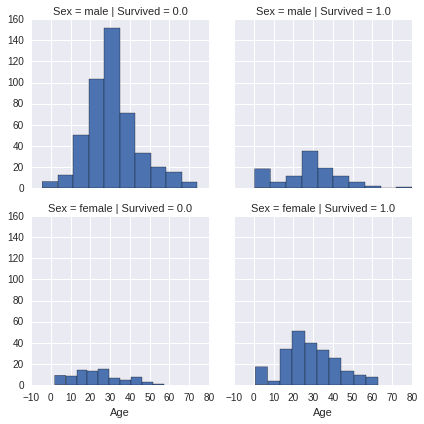

In [121]:
# Make some histograms to look at how survival is related to Age, seperated by sex
import seaborn as sns
g = sns.FacetGrid(df, row="Sex", col="Survived")
g.map(plt.hist, "Age")

I wanted to create something similar with pandas, but the features aren't ready yet in the current version. Still being worked on. 

Sex     Survived
female  0.0         [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
        1.0         [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
male    0.0         [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
        1.0         [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
dtype: object

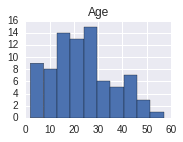

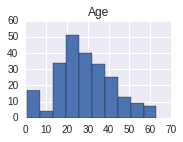

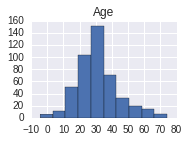

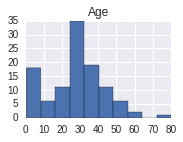

In [122]:
# try using hist on a groupby object
group = df.groupby(['Sex','Survived'])

group.hist(column = 'Age', layout = (2,2))

In [132]:
# Create the column child, and indicate whether child or adult
df['Child'] = 0
df['Child'][df['Age'] >= 18] = 'Adult'
df['Child'][df['Age'] < 18] = 'Child'

#print(df['Child'])
group = df.groupby(['Survived','Child'])

# Show counts
group['Child'].count() # These aren't quite the same - check.

/home/sophie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/sophie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Survived  Child
0.0       Adult    484
          Child     65
1.0       Adult    278
          Child     64
Name: Child, dtype: int64

In [12]:
# Adding Mother variable


All of the variables we care about should be taken care of and there should be no missing data. I’m going to double check just to be sure:

### Prediction

Our first step is to split the data back into the original test and training sets.

In [13]:
# check data

In [14]:
# Build a model using RandomForest

# Show model error

### Variable Importance

Let’s look at relative variable importance by plotting the mean decrease in Gini calculated across all trees.

In [15]:
# Get importance

# Create a rank variable based on importance

# Use ggplot2 to visualize the relative importance of variables

In [16]:
# Predict using the test set

# Save the solution to a dataframe with two columns: PassengerId and Survived (prediction)